## GCN node classification based on Cora dataset

In [11]:
import itertools
import os
import os.path as osp
import pickle
import urllib
from collections import namedtuple

import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import matplotlib.pyplot as plt

print('pytorch version:',torch.__version__, '\nnumpy version:' ,np.__version__)

%matplotlib inline

pytorch version: 1.5.0 
numpy version: 1.18.2


### Data processing(dataset: cora)

In [2]:
Data = namedtuple('Data', ['x', 'y', 'adjacency',
                           'train_mask', 'val_mask', 'test_mask'])

def tensor_from_numpy(x, device):
    return torch.from_numpy(x).to(device)

class CoraData(object):
    download_url = "https://github.com/kimiyoung/planetoid/raw/master/data"
    filenames = ["ind.cora.{}".format(name) for name in
                 ['x', 'tx', 'allx', 'y', 'ty', 'ally', 'graph', 'test.index']]

    def __init__(self, data_root="cora", rebuild=False):
        """Cora数据，包括数据下载，处理，加载等功能
        当数据的缓存文件存在时，将使用缓存文件，否则将下载、进行处理，并缓存到磁盘

        处理之后的数据可以通过属性 .data 获得，它将返回一个数据对象，包括如下几部分：
            * x: 节点的特征，维度为 2708 * 1433，类型为 np.ndarray
            * y: 节点的标签，总共包括7个类别，类型为 np.ndarray
            * adjacency: 邻接矩阵，维度为 2708 * 2708，类型为 scipy.sparse.coo.coo_matrix
            * train_mask: 训练集掩码向量，维度为 2708，当节点属于训练集时，相应位置为True，否则False
            * val_mask: 验证集掩码向量，维度为 2708，当节点属于验证集时，相应位置为True，否则False
            * test_mask: 测试集掩码向量，维度为 2708，当节点属于测试集时，相应位置为True，否则False

        Args:
        -------
            data_root: string, optional
                存放数据的目录，原始数据路径: {data_root}/raw
                缓存数据路径: {data_root}/processed_cora.pkl
            rebuild: boolean, optional
                是否需要重新构建数据集，当设为True时，如果存在缓存数据也会重建数据

        """
        self.data_root = data_root
        save_file = osp.join(self.data_root, "processed_cora.pkl")
        if osp.exists(save_file) and not rebuild:
            print("Using Cached file: {}".format(save_file))
            self._data = pickle.load(open(save_file, "rb"))
        else:
            self.maybe_download()
            self._data = self.process_data()
            with open(save_file, "wb") as f:
                pickle.dump(self.data, f)
            print("Cached file: {}".format(save_file))
    
    @property
    def data(self):
        """返回Data数据对象，包括x, y, adjacency, train_mask, val_mask, test_mask"""
        return self._data

    def process_data(self):
        """
        处理数据，得到节点特征和标签，邻接矩阵，训练集、验证集以及测试集
        引用自：https://github.com/rusty1s/pytorch_geometric
        """
        print("Process data ...")
        _, tx, allx, y, ty, ally, graph, test_index = [self.read_data(
            osp.join(self.data_root, "raw", name)) for name in self.filenames]
        train_index = np.arange(y.shape[0])
        val_index = np.arange(y.shape[0], y.shape[0] + 500)
        sorted_test_index = sorted(test_index)

        x = np.concatenate((allx, tx), axis=0)
        y = np.concatenate((ally, ty), axis=0).argmax(axis=1)

        x[test_index] = x[sorted_test_index]
        y[test_index] = y[sorted_test_index]
        num_nodes = x.shape[0]

        train_mask = np.zeros(num_nodes, dtype=np.bool)
        val_mask = np.zeros(num_nodes, dtype=np.bool)
        test_mask = np.zeros(num_nodes, dtype=np.bool)
        train_mask[train_index] = True
        val_mask[val_index] = True
        test_mask[test_index] = True
        adjacency = self.build_adjacency(graph)
        print("Node's feature shape: ", x.shape)
        print("Node's label shape: ", y.shape)
        print("Adjacency's shape: ", adjacency.shape)
        print("Number of training nodes: ", train_mask.sum())
        print("Number of validation nodes: ", val_mask.sum())
        print("Number of test nodes: ", test_mask.sum())

        return Data(x=x, y=y, adjacency=adjacency,
                    train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

    def maybe_download(self):
        save_path = os.path.join(self.data_root, "raw")
        for name in self.filenames:
            if not osp.exists(osp.join(save_path, name)):
                self.download_data(
                    "{}/{}".format(self.download_url, name), save_path)

    @staticmethod
    def build_adjacency(adj_dict):
        """根据邻接表创建邻接矩阵"""
        edge_index = []
        num_nodes = len(adj_dict)
        for src, dst in adj_dict.items():
            edge_index.extend([src, v] for v in dst)
            edge_index.extend([v, src] for v in dst)
        # 去除重复的边
        edge_index = list(k for k, _ in itertools.groupby(sorted(edge_index)))
        edge_index = np.asarray(edge_index)
        adjacency = sp.coo_matrix((np.ones(len(edge_index)), 
                                   (edge_index[:, 0], edge_index[:, 1])),
                    shape=(num_nodes, num_nodes), dtype="float32")
        return adjacency

    @staticmethod
    def read_data(path):
        """使用不同的方式读取原始数据以进一步处理"""
        name = osp.basename(path)
        if name == "ind.cora.test.index":
            out = np.genfromtxt(path, dtype="int64")
            return out
        else:
            out = pickle.load(open(path, "rb"), encoding="latin1")
            out = out.toarray() if hasattr(out, "toarray") else out
            return out

    @staticmethod
    def download_data(url, save_path):
        """数据下载工具，当原始数据不存在时将会进行下载"""
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        data = urllib.request.urlopen(url)
        filename = os.path.split(url)[-1]

        with open(os.path.join(save_path, filename), 'wb') as f:
            f.write(data.read())

        return True

    @staticmethod
    def normalization(adjacency):
        """计算 L=D^-0.5 * (A+I) * D^-0.5"""
        adjacency += sp.eye(adjacency.shape[0])    # 增加自连接
        degree = np.array(adjacency.sum(1))
        d_hat = sp.diags(np.power(degree, -0.5).flatten())
        return d_hat.dot(adjacency).dot(d_hat).tocoo()

### Define gcn layer

In [3]:
class GraphConvolution(nn.Module):
    def __init__(self, input_dim, output_dim, use_bias=True):
        """图卷积：L*X*\theta

        Args:
        ----------
            input_dim: int
                节点输入特征的维度
            output_dim: int
                输出特征维度
            use_bias : bool, optional
                是否使用偏置
        """
        super(GraphConvolution, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_bias = use_bias
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim))
        if self.use_bias:
            self.bias = nn.Parameter(torch.Tensor(output_dim))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight)
        if self.use_bias:
            init.zeros_(self.bias)

    def forward(self, adjacency, input_feature):
        """邻接矩阵是稀疏矩阵，因此在计算时使用稀疏矩阵乘法
    
        Args: 
        -------
            adjacency: torch.sparse.FloatTensor
                邻接矩阵
            input_feature: torch.Tensor
                输入特征
        """
        support = torch.mm(input_feature, self.weight)
        output = torch.sparse.mm(adjacency, support)
        if self.use_bias:
            output += self.bias
        return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
            + str(self.input_dim) + ' -> ' \
            + str(self.output_dim) + ')'
    

### Define model

In [4]:
class GCN(nn.Module):
    """
    定义一个包含两层GraphConvolution的模型
    """
    def __init__(self, input_dim=1433):
        super(GCN, self).__init__()
        self.gcn1 = GraphConvolution(input_dim, 16)
        self.gcn2 = GraphConvolution(16, 7)
    
    def forward(self, adjacency, feature):
        h = F.relu(self.gcn1(adjacency, feature))
        logits = self.gcn2(adjacency, h)
        return logits

### Define hyperparameters

In [5]:
LEARNING_RATE = 0.1
WEIGHT_DACAY = 5e-4
EPOCHS = 20
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

In [6]:
# 加载数据，并转换为torch.Tensor
dataset = CoraData(data_root='./data/cora').data
node_feature = dataset.x / dataset.x.sum(1, keepdims=True)  # 归一化数据，使得每一行和为1
tensor_x = tensor_from_numpy(node_feature, DEVICE)
tensor_y = tensor_from_numpy(dataset.y, DEVICE)
tensor_train_mask = tensor_from_numpy(dataset.train_mask, DEVICE)
tensor_val_mask = tensor_from_numpy(dataset.val_mask, DEVICE)
tensor_test_mask = tensor_from_numpy(dataset.test_mask, DEVICE)
normalize_adjacency = CoraData.normalization(dataset.adjacency)   # 规范化邻接矩阵

num_nodes, input_dim = node_feature.shape
indices = torch.from_numpy(np.asarray([normalize_adjacency.row, 
                                       normalize_adjacency.col]).astype('int64')).long()
values = torch.from_numpy(normalize_adjacency.data.astype(np.float32))
tensor_adjacency = torch.sparse.FloatTensor(indices, values, 
                                            (num_nodes, num_nodes)).to(DEVICE)

Process data ...
Node's feature shape:  (2708, 1433)
Node's label shape:  (2708,)
Adjacency's shape:  (2708, 2708)
Number of training nodes:  140
Number of validation nodes:  500
Number of test nodes:  1000
Cached file: ./data/cora/processed_cora.pkl


### Init model, define optimizer and loss function

In [7]:
# 模型定义：Model, Loss, Optimizer
model = GCN(input_dim).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DACAY)

### Define training function

In [8]:
def train():
    loss_history = []
    val_acc_history = []
    model.train()
    train_y = tensor_y[tensor_train_mask]
    for epoch in range(EPOCHS):
        logits = model(tensor_adjacency, tensor_x)  # 前向传播
        train_mask_logits = logits[tensor_train_mask]   # 只选择训练节点进行监督
        loss = criterion(train_mask_logits, train_y)    # 计算损失值
        optimizer.zero_grad()
        loss.backward()     # 反向传播计算参数的梯度
        optimizer.step()    # 使用优化方法进行梯度更新
        train_acc, _, _ = test(tensor_train_mask)     # 计算当前模型训练集上的准确率
        val_acc, _, _ = test(tensor_val_mask)     # 计算当前模型在验证集上的准确率
        # 记录训练过程中损失值和准确率的变化，用于画图
        loss_history.append(loss.item())
        val_acc_history.append(val_acc.item())
        print("Epoch {:03d}: Loss {:.4f}, TrainAcc {:.4}, ValAcc {:.4f}".format(
            epoch, loss.item(), train_acc.item(), val_acc.item()))
    
    return loss_history, val_acc_history

def test(mask):
    model.eval()
    with torch.no_grad():
        logits = model(tensor_adjacency, tensor_x)
        test_mask_logits = logits[mask]
        predict_y = test_mask_logits.max(1)[1]
        accuarcy = torch.eq(predict_y, tensor_y[mask]).float().mean()
    return accuarcy, test_mask_logits.cpu().numpy(), tensor_y[mask].cpu().numpy()

### Visualize the training process

In [9]:
def plot_loss_with_acc(loss_history, val_acc_history):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(range(len(loss_history)), loss_history,
             c=np.array([255, 71, 90]) / 255.)
    plt.ylabel('Loss')
    
    ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
    ax2.plot(range(len(val_acc_history)), val_acc_history,
             c=np.array([79, 179, 255]) / 255.)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    plt.ylabel('ValAcc')
    
    plt.xlabel('Epoch')
    plt.title('Training Loss & Validation Accuracy')
    plt.show()

### Training model

/pytorch/aten/src/ATen/native/BinaryOps.cpp:66: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


Epoch 000: Loss 1.9548, TrainAcc 0.2429, ValAcc 0.1980
Epoch 001: Loss 1.8852, TrainAcc 0.4, ValAcc 0.2180
Epoch 002: Loss 1.8062, TrainAcc 0.5857, ValAcc 0.3180
Epoch 003: Loss 1.6876, TrainAcc 0.7571, ValAcc 0.5360
Epoch 004: Loss 1.5597, TrainAcc 0.8214, ValAcc 0.5820
Epoch 005: Loss 1.4106, TrainAcc 0.8929, ValAcc 0.6400
Epoch 006: Loss 1.2509, TrainAcc 0.95, ValAcc 0.7020
Epoch 007: Loss 1.0888, TrainAcc 0.9429, ValAcc 0.7320
Epoch 008: Loss 0.9362, TrainAcc 0.95, ValAcc 0.7420
Epoch 009: Loss 0.7979, TrainAcc 0.9714, ValAcc 0.7500
Epoch 010: Loss 0.6735, TrainAcc 0.9786, ValAcc 0.7580
Epoch 011: Loss 0.5741, TrainAcc 0.9786, ValAcc 0.7740
Epoch 012: Loss 0.4906, TrainAcc 0.9786, ValAcc 0.7780
Epoch 013: Loss 0.4216, TrainAcc 0.9857, ValAcc 0.7760
Epoch 014: Loss 0.3689, TrainAcc 0.9857, ValAcc 0.7800
Epoch 015: Loss 0.3287, TrainAcc 0.9929, ValAcc 0.7860
Epoch 016: Loss 0.2957, TrainAcc 0.9929, ValAcc 0.7940
Epoch 017: Loss 0.2713, TrainAcc 0.9929, ValAcc 0.7920
Epoch 018: Loss 0

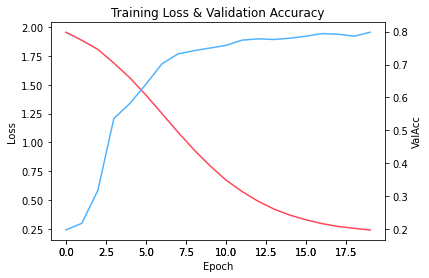

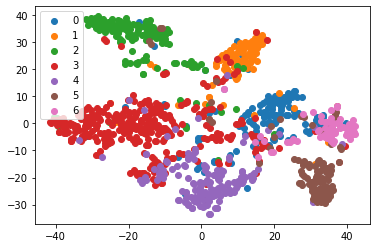

In [10]:
loss, val_acc = train()
test_acc, test_logits, test_label = test(tensor_test_mask)
print("Test accuarcy: ", test_acc.item())

plot_loss_with_acc(loss, val_acc)

# 绘制测试数据的TSNE降维图
from sklearn.manifold import TSNE
tsne = TSNE()
out = tsne.fit_transform(test_logits)
fig = plt.figure()
for i in range(7):
    indices = test_label == i
    x, y = out[indices].T
    plt.scatter(x, y, label=str(i))
plt.legend()